# ECON-323 Final Project - Brazilian E-Commerce Dataset Analysis
### Name: Ahnaf Tazwar Ayub
### Student #: 35562164

## Sections
***

### 1. Introduction to Olist E-Commerce Dataset
### 2. Analysis Goals
### 3. Products Analysis
####    - 3.1: Attributes
####    - 3.2: Freight Cost Prediction
### 4. Sales Forecasting
####    - 4.1: Time Series Formulation
####    - 4.2: Autoregressive Model
### 5. Delivery Time Analysis
####    - 5.1: Geographical Analysis
####    - 5.2: Delivery Time Prediction
### 6. Conclusions/Future Extensions

***

# 1. Introduction to Olist E-Commerce Dataset
***

- Talk about the context behind the data
- Talk about the potential avenues for analysis
- Benefits of analysis
- Structure of data

## Imports/Data

Before we can get underway with our in-depth analysis, we must start off by importing the necessary libraries. We will be using a mix of different computational resources, aimed at assisting us with tasks related to visualization, prediction and so forth. 

Furthermore, to streamline the process of loading and working with the 9 separate datasets provided by Olist on Kaggle, we can define a function like **load(datasetName)** below.

In [1]:
#Imports
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#Data paths
datadir = os.path.join(os.getcwd(), 'archive')

# Simply maps each table name to the appropriate .csv file
data_map = {
    "customers" : os.path.join(datadir, 'olist_customers_dataset.csv'),
    "geolocation" : os.path.join(datadir, 'olist_geolocation_dataset.csv'),
    #Orders
    "order_items" : os.path.join(datadir, 'olist_order_items_dataset.csv'),
    "order_payments" : os.path.join(datadir, 'olist_order_payments_dataset.csv'),
    "order_reviews" : os.path.join(datadir, 'olist_order_reviews_dataset.csv'),
    # MAIN DATA
    "orders" : os.path.join(datadir, 'olist_orders_dataset.csv'),
    #Products
    "products" : os.path.join(datadir, 'olist_products_dataset.csv'),
    "sellers" : os.path.join(datadir, 'olist_sellers_dataset.csv'),
    "prod2cat_translation" : os.path.join(datadir, 'product_category_name_translation.csv')
}

def load(df_name):
    return pd.read_csv(data_map[df_name])

# 2. Analysis Goals
***

# 3. Products Analysis
***

### Data

From the given data, we have access to a DataFrame that contains information on the products sold on the platform. It is worth noting that the category names are in Portuguese by default, so we can leverage the provided **translation** DataFrame to convert them to English.

In [2]:
products_df = load('products')
translate = load("prod2cat_translation")
print(f'Products: {products_df.shape}')
print(f'Translate: {translate.shape}')
products_df.head()

Products: (32951, 9)
Translate: (71, 2)


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [3]:
translate.head()

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


In [4]:
prod_translated = products_df.merge(translate, on='product_category_name')
print(prod_translated.shape)
prod_translated.head()

(32328, 10)


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0,perfumery
1,6a2fb4dd53d2cdb88e0432f1284a004c,perfumaria,39.0,346.0,2.0,400.0,27.0,5.0,20.0,perfumery
2,0d009643171aee696f4733340bc2fdd0,perfumaria,52.0,150.0,1.0,422.0,21.0,16.0,18.0,perfumery
3,b1eae565a61935e0011ee7682fef9dc9,perfumaria,49.0,460.0,2.0,267.0,17.0,13.0,17.0,perfumery
4,8da90b37f0fb171b4877c124f965b1f6,perfumaria,56.0,733.0,3.0,377.0,18.0,13.0,15.0,perfumery


## Physical Properties

Given the information we have (i.e. product weight, dimensions) can quite easily find out the categories with the heaviest and most dense products.  

In [5]:
prod_translated['product_volume_cm3'] = prod_translated['product_length_cm'] *prod_translated['product_height_cm']*prod_translated['product_width_cm']
prod_translated['product_volume_cm3']   

0          2240.0
1          2700.0
2          6048.0
3          3757.0
4          3510.0
           ...   
32323     15625.0
32324     18081.0
32325    262800.0
32326     70000.0
32327     13125.0
Name: product_volume_cm3, Length: 32328, dtype: float64

In [6]:
cat_gby = prod_translated.groupby('product_category_name_english') #Group-by category

most_vol = cat_gby['product_volume_cm3'].mean().sort_values(ascending=False).head(n=10) #Products with most volume
most_weight = cat_gby['product_weight_g'].mean().sort_values(ascending=False).head(n=10) #products with most weight

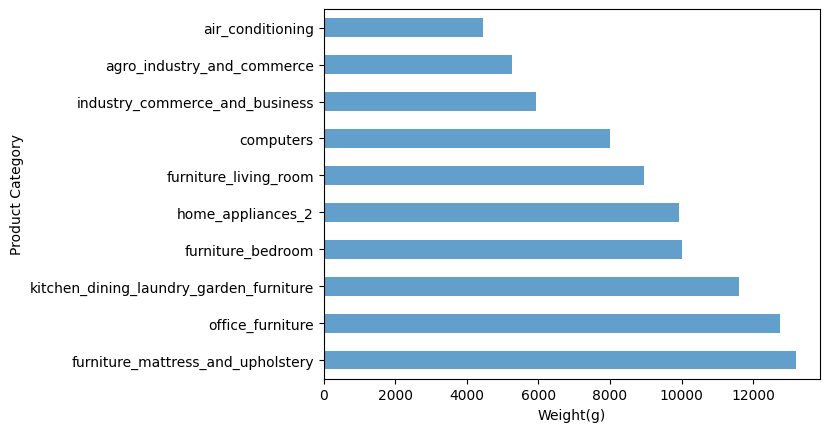

In [7]:
ax = most_weight.plot.barh(alpha=0.7)
ax.set_ylabel('Product Category')
ax.set_xlabel('Weight(g)')
plt.show()

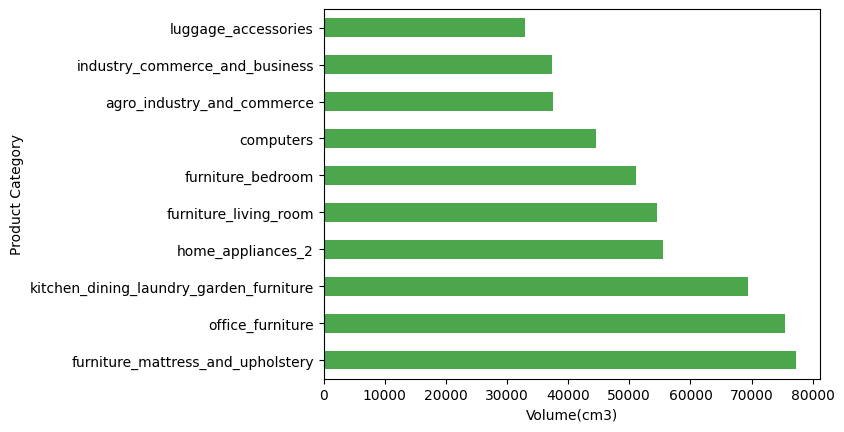

In [8]:
ax = most_vol.plot.barh(alpha=0.7, color='green')
ax.set_ylabel('Product Category')
ax.set_xlabel('Volume(cm3)')
plt.show()

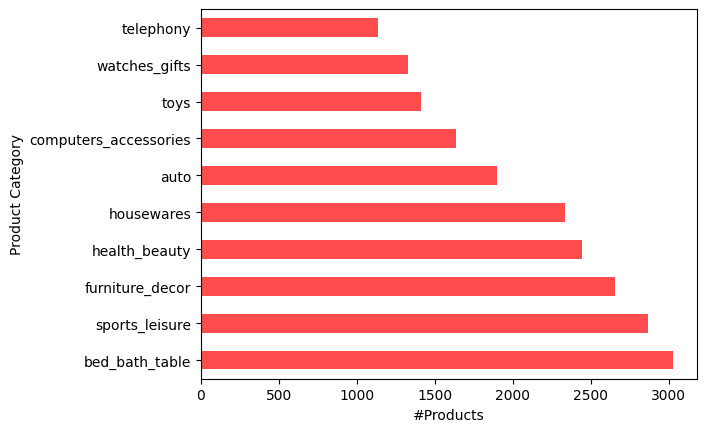

In [9]:
most_prods = cat_gby['product_id'].count().sort_values(ascending=False).head(n=10)
ax = most_prods.plot.barh(alpha=0.7, color='red')
ax.set_ylabel('Product Category')
ax.set_xlabel('#Products')
plt.show()

## OrderItems

In [10]:
orderitems_df = load('order_items')
orderitems_df.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


We **join** with the products table, in order to find stats regarding product prices and associated freight costs.

In [11]:
ord2prod = orderitems_df.merge(prod_translated, on='product_id')
ord2prod.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,product_volume_cm3
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff,3528.0
1,130898c0987d1801452a8ed92a670612,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-07-05 02:44:11,55.9,17.96,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff,3528.0
2,532ed5e14e24ae1f0d735b91524b98b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2018-05-23 10:56:25,64.9,18.33,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff,3528.0
3,6f8c31653edb8c83e1a739408b5ff750,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-07 18:55:08,58.9,16.17,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff,3528.0
4,7d19f4ef4d04461989632411b7e588b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-16 22:05:11,58.9,13.29,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff,3528.0


In [12]:
print(ord2prod[['order_id', 'product_id']].duplicated().any())
print(ord2prod[['order_id', 'product_id', 'order_item_id']].duplicated().any())

True
False


In [13]:
# Test case
ord2prod.groupby(['order_id', 'product_id']).get_group(('00143d0f86d6fbd9f9b38ab440ac16f5', 'e95ee6822b66ac6058e2e4aff656071a'))

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,product_volume_cm3
1315,00143d0f86d6fbd9f9b38ab440ac16f5,1,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1,esporte_lazer,52.0,1153.0,1.0,180.0,17.0,11.0,14.0,sports_leisure,2618.0
1316,00143d0f86d6fbd9f9b38ab440ac16f5,2,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1,esporte_lazer,52.0,1153.0,1.0,180.0,17.0,11.0,14.0,sports_leisure,2618.0
1317,00143d0f86d6fbd9f9b38ab440ac16f5,3,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1,esporte_lazer,52.0,1153.0,1.0,180.0,17.0,11.0,14.0,sports_leisure,2618.0


In [14]:
ord_stats = ord2prod.groupby(['order_id', 'product_id'])[[ 'product_weight_g','product_volume_cm3', 'price', 'freight_value',]].sum()
if ord_stats.duplicated().any():
    ord_stats = ord_stats.drop_duplicates()
ord_stats

,,product_weight_g,product_volume_cm3,price,freight_value
order_id,product_id,,,,
00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,650.0,3528.0,58.90,13.29
00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,30000.0,60000.0,239.90,19.93
000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,3050.0,14157.0,199.00,17.87
00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,200.0,2400.0,12.99,12.79
00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,3750.0,42000.0,199.90,18.14
...,...,...,...,...,...
fffb2ef8874127f75b52b643880fd7e0,ebceb9726cf5c6187b48e17fe58747b0,200.0,2250.0,17.90,22.06
fffb9224b6fc7c43ebb0904318b10b5f,43423cdffde7fda63d0414ed38c11a73,1400.0,9856.0,220.00,136.76
fffc94f6ce00a00581880bf54a75a037,4aa6014eceb682077f9dc4bffebc05b0,10150.0,53400.0,299.99,43.41


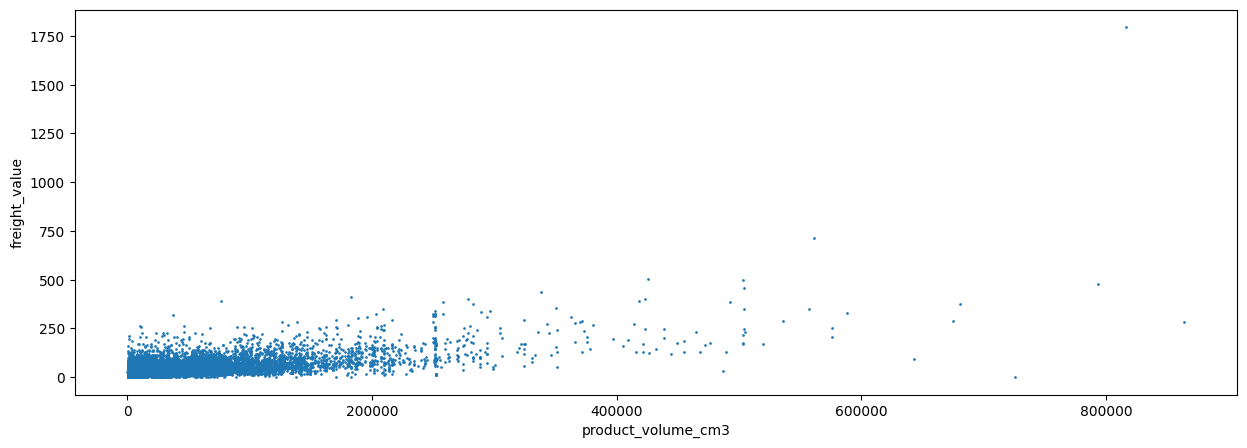

In [15]:
# ord_stats = ord_stats.loc[(ord_stats['freight_value'] < 200) & (ord_stats['product_volume_cm3'] < 5e3)]
ax = ord_stats.plot.scatter(x = 'product_volume_cm3', y = 'freight_value', figsize=(15,5), s=0.9)
plt.show()

### Freight Cost Predictor

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model

data = ord_stats[['product_weight_g', 'product_volume_cm3', 'freight_value']]

X = data[['product_weight_g', 'product_volume_cm3']].values
y = data['freight_value'].values
print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')
#Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)
print(f'X_train shape: {X_train.shape} \t X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape} \t y_test shape: {y_test.shape}')

X shape: (73031, 2)
y shape: (73031,)
X_train shape: (69379, 2) 	 X_test shape: (3652, 2)
y_train shape: (69379,) 	 y_test shape: (3652,)


In [17]:
model = RandomForestRegressor(n_estimators = 20 , max_depth=8, random_state=0, n_jobs=-1)
model.fit(X_train, y_train)

yhat_train = model.predict(X_train)
yhat_test = model.predict(X_test)

#Errors
errors = {}
errors['train_rmse'] = np.sqrt(mean_squared_error(y_train, yhat_train))
errors['test_rmse'] = np.sqrt(mean_squared_error(y_test, yhat_test))
errors['train_mae'] = mean_absolute_error(y_train, yhat_train)
errors['test_mae'] = mean_absolute_error(y_test, yhat_test)
errors['train_r2'] = r2_score(y_train, yhat_train)
errors['test_r2'] = r2_score(y_test, yhat_test)

errors

{'train_rmse': 15.38753937921717,
 'test_rmse': 14.685198438899997,
 'train_mae': 8.87355841855605,
 'test_mae': 8.712778469380314,
 'train_r2': 0.5518740945186142,
 'test_r2': 0.46481016075971315}

In [18]:
test_point = {'product_weight_g':700.0, 'product_volume_cm3':3600.0}
round(model.predict([[test_point['product_weight_g'], test_point['product_volume_cm3']]])[0], 2)

18.45

# 4. Sales Forecasting
***

In [19]:
orders_main = load('orders')
orders_main.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [20]:
#Contains all the available information (order times, product info)
orders_full = ord2prod.merge(orders_main, on = 'order_id')
orders_full.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,...,product_width_cm,product_category_name_english,product_volume_cm3,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,cool_stuff,58.0,598.0,...,14.0,cool_stuff,3528.0,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29 00:00:00
1,130898c0987d1801452a8ed92a670612,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-07-05 02:44:11,55.9,17.96,cool_stuff,58.0,598.0,...,14.0,cool_stuff,3528.0,e6eecc5a77de221464d1c4eaff0a9b64,delivered,2017-06-28 11:52:20,2017-06-29 02:44:11,2017-07-05 12:00:33,2017-07-13 20:39:29,2017-07-26 00:00:00
2,532ed5e14e24ae1f0d735b91524b98b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2018-05-23 10:56:25,64.9,18.33,cool_stuff,58.0,598.0,...,14.0,cool_stuff,3528.0,4ef55bf80f711b372afebcb7c715344a,delivered,2018-05-18 10:25:53,2018-05-18 12:31:43,2018-05-23 14:05:00,2018-06-04 18:34:26,2018-06-07 00:00:00
3,6f8c31653edb8c83e1a739408b5ff750,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-07 18:55:08,58.9,16.17,cool_stuff,58.0,598.0,...,14.0,cool_stuff,3528.0,30407a72ad8b3f4df4d15369126b20c9,delivered,2017-08-01 18:38:42,2017-08-01 18:55:08,2017-08-02 19:07:36,2017-08-09 21:26:33,2017-08-25 00:00:00
4,7d19f4ef4d04461989632411b7e588b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-16 22:05:11,58.9,13.29,cool_stuff,58.0,598.0,...,14.0,cool_stuff,3528.0,91a792fef70ecd8cc69d3c7feb3d12da,delivered,2017-08-10 21:48:40,2017-08-10 22:05:11,2017-08-11 19:43:07,2017-08-24 20:04:21,2017-09-01 00:00:00


In [21]:
orders_full['order_purchase_timestamp'] = pd.to_datetime(orders_full.order_purchase_timestamp)
df_ts = orders_full.set_index('order_purchase_timestamp').sort_index()
df_ts

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,...,product_height_cm,product_width_cm,product_category_name_english,product_volume_cm3,customer_id,order_status,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
order_purchase_timestamp,,,,,,,,,,,,,,,,,,,,,
2016-09-04 21:15:19,2e7a8482f6fb09756ca50c10d7bfc047,2,f293394c72c9b5fafd7023301fc21fc2,1554a68530182680ad5c8b042c3ab563,2016-10-26 18:25:19,32.90,31.67,moveis_decoracao,41.0,754.0,...,6.0,28.0,furniture_decor,5376.0,08c5351a6aca1c1589a38f244edeee9d,shipped,2016-10-07 13:18:03,2016-10-18 13:14:51,NaN,2016-10-20 00:00:00
2016-09-04 21:15:19,2e7a8482f6fb09756ca50c10d7bfc047,1,c1488892604e4ba5cff5b4eb4d595400,1554a68530182680ad5c8b042c3ab563,2016-10-26 18:25:19,39.99,31.67,moveis_decoracao,59.0,426.0,...,6.0,28.0,furniture_decor,5376.0,08c5351a6aca1c1589a38f244edeee9d,shipped,2016-10-07 13:18:03,2016-10-18 13:14:51,NaN,2016-10-20 00:00:00
2016-09-05 00:15:34,e5fa5a7210941f7d56d0208e4e071d35,1,f3c2d01a84c947b078e32bbef0718962,a425f92c199eb576938df686728acd20,2016-09-19 00:15:34,59.50,15.56,telefonia,42.0,381.0,...,2.0,25.0,telephony,1250.0,683c54fc24d40ee9f8a6fc179fd9856c,canceled,2016-10-07 13:17:15,NaN,NaN,2016-10-28 00:00:00
2016-09-15 12:16:38,bfbd0f9bdef84302105ad712db648a6c,1,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,2016-09-19 23:11:33,44.99,2.83,beleza_saude,34.0,1036.0,...,16.0,16.0,health_beauty,4096.0,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15 12:16:38,2016-11-07 17:11:53,2016-11-09 07:47:38,2016-10-04 00:00:00
2016-09-15 12:16:38,bfbd0f9bdef84302105ad712db648a6c,2,5a6b04657a4c5ee34285d1e4619a96b4,ecccfa2bb93b34a3bf033cc5d1dcdc69,2016-09-19 23:11:33,44.99,2.83,beleza_saude,34.0,1036.0,...,16.0,16.0,health_beauty,4096.0,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15 12:16:38,2016-11-07 17:11:53,2016-11-09 07:47:38,2016-10-04 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-29 14:18:23,0b223d92c27432930dfe407c6aea3041,1,2b4472df15512a2825ae86fd9ae79335,67bf6941ba2f1fa1d02c375766bc3e53,2018-08-31 14:30:19,209.00,46.48,moveis_cozinha_area_de_servico_jantar_e_jardim,44.0,112.0,...,49.0,49.0,kitchen_dining_laundry_garden_furniture,115248.0,e60df9449653a95af4549bbfcb18a6eb,delivered,2018-08-29 14:31:07,2018-08-29 15:29:00,2018-08-30 16:24:55,2018-09-04 00:00:00
2018-08-29 14:18:28,168626408cb32af0ffaf76711caae1dc,1,bdcf6a834e8faa30dac3886c7a58e92e,2a84855fd20af891be03bc5924d2b453,2018-08-31 14:30:23,45.90,15.39,beleza_saude,26.0,394.0,...,16.0,28.0,health_beauty,13888.0,6e353700bc7bcdf6ebc15d6de16d7002,delivered,2018-08-29 14:30:23,2018-08-29 18:51:00,2018-08-30 16:52:31,2018-09-11 00:00:00
2018-08-29 14:52:00,03ef5dedbe7492bdae72eec50764c43f,1,c7f27c5bef2338541c772b5776403e6a,7d7866a99a8656a42c7ff6352a433410,2018-08-31 15:05:22,24.90,8.33,artigos_de_festas,54.0,429.0,...,9.0,19.0,party_supplies,4788.0,496630b6740bcca28fce9ba50d8a26ef,delivered,2018-08-29 15:05:22,2018-08-29 20:01:00,2018-08-30 16:36:59,2018-09-03 00:00:00


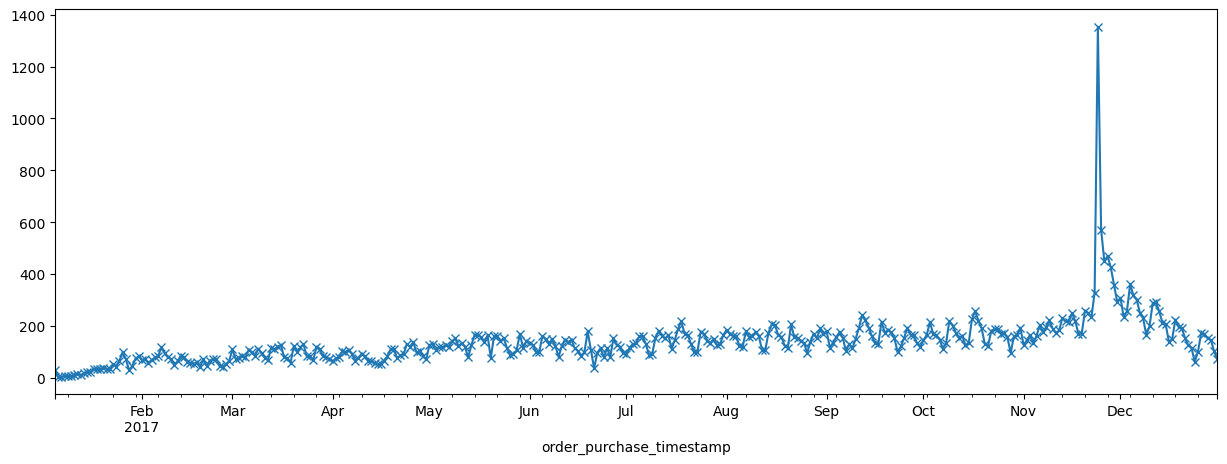

In [22]:
df_ts.loc['2017'].resample('D')['price'].count().plot(figsize=(15,5), marker='x')
plt.show()

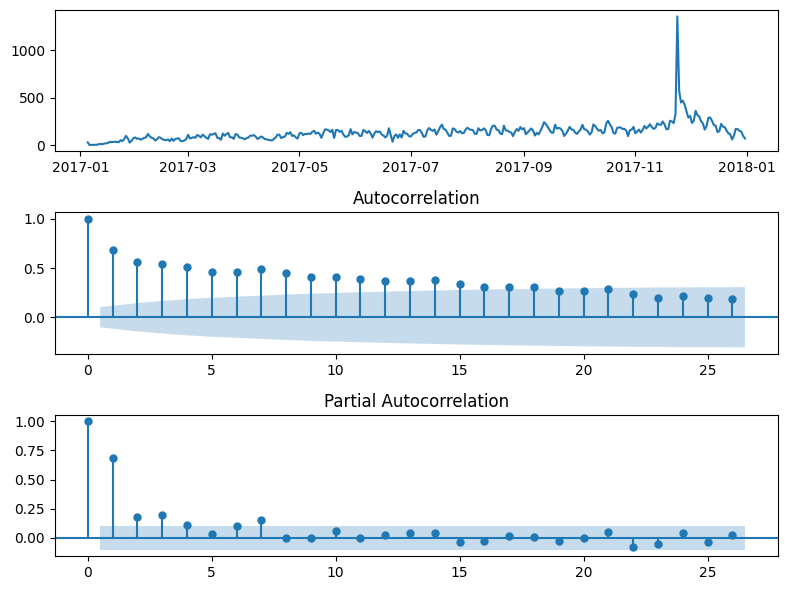

In [23]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (a1, a2, a3) = plt.subplots(3, 1, figsize=(8,6))
series_17 = df_ts.loc['2017'].resample('d')['price'].count()
series = pd.concat([series_17,])
a1.plot(series)
plot_acf(series, ax=a2)
plot_pacf(series, ax=a3)
plt.tight_layout()
plt.show()

In [24]:
#create a train-test split
test_size = 5 #in days
xt_train = series[:-test_size]
xt_test = series[-test_size:]
print(f'Train data shape: {xt_train.shape}')
print(f'Test data shape: {xt_test.shape}')
assert len(xt_train) + len(xt_test) == len(series)

Train data shape: (356,)
Test data shape: (5,)


In [25]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
#https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html#ARIMA-Postestimation:-Example-1---Dynamic-Forecasting

models = {
    'AR1': SARIMAX(xt_train, order= (1, 0, 0 )),
    'MA1':SARIMAX(xt_train, order= (0, 0, 1 )),
    'ARMA11':SARIMAX(xt_train, order= (1, 0, 1 ))
}

model = models['AR1']
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  price   No. Observations:                  356
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -2038.830
Date:                Mon, 11 Apr 2022   AIC                           4081.660
Time:                        18:15:29   BIC                           4089.409
Sample:                    01-05-2017   HQIC                          4084.742
                         - 12-26-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8972      0.006    153.779      0.000       0.886       0.909
sigma2      5495.0320     50.821    108.126      0.000    5395.425    5594.639
===================================================================================
Ljung-Box (Q):                       75.40   Jarque-Bera (JB):            273172.94
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              32.18   Skew:                             6.29
Prob(H) (two-sided):                  0.00   Kurtosis:                       138.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

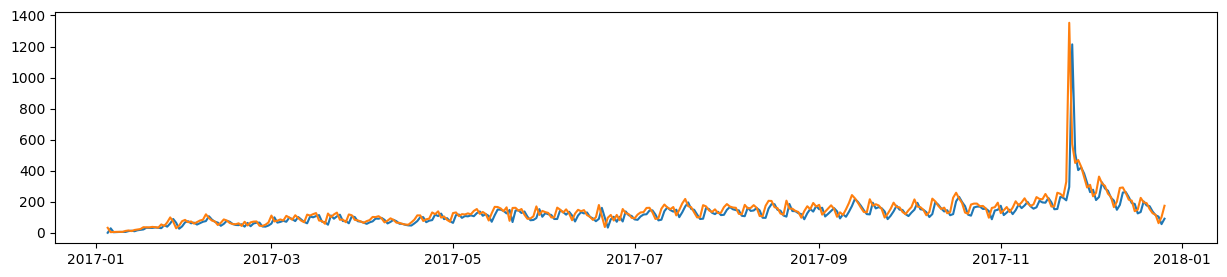

In [26]:
predict = res.get_prediction()
predict_ci = predict.conf_int()
fig, ax = plt.subplots(figsize=(15,3))
ax.plot(predict.predicted_mean)
ax.plot(xt_train)
plt.show()

In [27]:
forecasts = res.get_forecast(steps=len(xt_test)).summary_frame()
forecasts.head()

price,mean,mean_se,mean_ci_lower,mean_ci_upper
2017-12-27,156.114600,74.128483,10.825444,301.403757
2017-12-28,140.067635,99.591456,-55.128031,335.263301
2017-12-29,125.670131,116.100198,-101.882074,353.222337
2017-12-30,112.752542,127.850107,-137.829062,363.334147
2017-12-31,101.162748,136.576198,-166.521682,368.847177


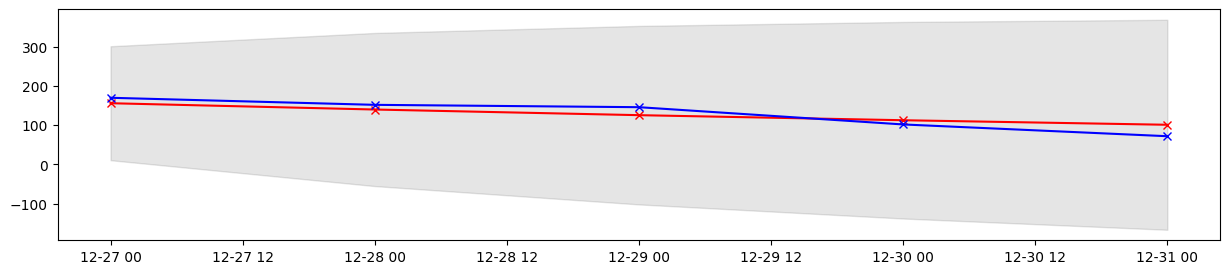

In [28]:
#https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_forecasting.html
fig, ax = plt.subplots(figsize=(15,3))

ax.plot(forecasts['mean'], color='red', marker = 'x')
ax.fill_between(forecasts.index, forecasts['mean_ci_lower'], forecasts['mean_ci_upper'], color='k', alpha=0.1)
ax.plot(xt_test, color='blue', marker = 'x')
plt.show()

In [29]:
errors = {
    'rmse': np.sqrt(mean_squared_error(xt_test, forecasts['mean'].values)),
    'mae': mean_absolute_error(xt_test, forecasts['mean'].values)
}
errors

{'rmse': 18.517949283606377, 'mae': 17.212584620416024}

# 5. Delivery Time Analysis
***

In [30]:
orderitems_df = load('order_items')
orderitems_df.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


Load main orders dataset

In [31]:
orders_main = load('orders')
print(orders_main.shape)
orders_main = orders_main.loc[orders_main.order_status == 'delivered']
print(orders_main.shape)
orders_main.head()

(99441, 8)
(96478, 8)


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


Find the delivery times.

In [32]:
orders_main['order_delivered_customer_date'] = pd.to_datetime(orders_main['order_delivered_customer_date'])
orders_main['order_delivered_carrier_date'] = pd.to_datetime(orders_main['order_delivered_carrier_date'])
orders_main['delivery_time'] = orders_main.order_delivered_customer_date - orders_main.order_delivered_carrier_date
orders_main['delivery_time'] = orders_main['delivery_time'].dt.days
print(orders_main.shape)
orders_main = orders_main.loc[~orders_main.delivery_time.isnull()] #Remove null rows
print(orders_main.shape)
orders_main = orders_main.loc[orders_main.delivery_time >= 0] #Remove invalid
print(orders_main.shape)

(96478, 9)
(96469, 9)
(96446, 9)


Find where customers and sellers are.

In [33]:
customers = load('customers')
customers

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP
...,...,...,...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS


In [34]:
sellers = load('sellers')
sellers

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP
...,...,...,...,...
3090,98dddbc4601dd4443ca174359b237166,87111,sarandi,PR
3091,f8201cab383e484733266d1906e2fdfa,88137,palhoca,SC
3092,74871d19219c7d518d0090283e03c137,4650,sao paulo,SP
3093,e603cf3fec55f8697c9059638d6c8eb5,96080,pelotas,RS


In [35]:
ord2prod = orderitems_df.merge(prod_translated, on='product_id')
ord_stats = ord2prod.groupby(['order_id', 'product_id', 'seller_id'])[[ 'product_weight_g','price', 'freight_value',]].sum()
ord_stats

,,,product_weight_g,price,freight_value
order_id,product_id,seller_id,,,
00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,650.0,58.90,13.29
00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,30000.0,239.90,19.93
000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,3050.0,199.00,17.87
00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,200.0,12.99,12.79
00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,3750.0,199.90,18.14
...,...,...,...,...,...
fffc94f6ce00a00581880bf54a75a037,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,10150.0,299.99,43.41
fffcd46ef2263f404302a634eb57f7eb,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,8950.0,350.00,36.53
fffce4705a9662cd70adb13d4a31832d,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,967.0,99.90,16.95


In [36]:
ordstats_sellers = ord_stats.reset_index().merge(sellers, on='seller_id')
ordstats_sellers

,order_id,product_id,seller_id,product_weight_g,price,freight_value,seller_zip_code_prefix,seller_city,seller_state
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,650.0,58.90,13.29,27277,volta redonda,SP
1,0188777fe321843a18be24a6e9aa1e53,436c8d57ff8d4aa254318e9bd9b48c83,48436dade18ac8b2bce089ec2a041202,530.0,55.90,9.94,27277,volta redonda,SP
2,0191bbb5166d4b9a68df11797d5acfa9,ec02a5d380128f7a188e9ce8f3ddd832,48436dade18ac8b2bce089ec2a041202,2275.0,132.90,20.17,27277,volta redonda,SP
3,03054d8a8eefc2981cfad06f58e27979,3e31fd1419cc4cd6adad1925e72e3a03,48436dade18ac8b2bce089ec2a041202,400.0,58.90,15.16,27277,volta redonda,SP
4,0c325ea6925de749e1420be0cf43587c,3a135477bf41350a0b1d8afdf616d446,48436dade18ac8b2bce089ec2a041202,600.0,139.90,16.74,27277,volta redonda,SP
...,...,...,...,...,...,...,...,...,...
100938,fdaf98feac227eb978d8f33f36e0231d,f739e9151702508b18f796c53005e5e9,d1aa1ec0839dcab73a6161130eb1f94a,1000.0,119.90,16.14,80220,curitiba,PR
100939,fdfeec75aa07c1d2a88b17b8fbfc7b8f,11059273f4bc1a293777e98c89807c62,dbc51f5e45d654ecc16cb68e6817ecea,1050.0,199.99,18.14,14402,franca,SP
100940,fe68b52db13993f58175fa589125d345,f4135cbdece8245560f7be179533797a,3fefda3299e6dfaea3466ef346a3571a,500.0,209.00,16.21,82620,curitiba,PR
100941,fefacc66af859508bf1a7934eab1e97f,69c590f7ffc7bf8db97190b6cb6ed62e,80ceebb4ee9b31afb6c6a916a574a1e2,5660.0,6729.00,193.21,86026,londrina,PR


In [37]:
orders_full = orders_main.merge(customers, on='customer_id').merge(ordstats_sellers, on = 'order_id')
print(orders_full[['order_id', 'customer_id', 'seller_id']].duplicated().any())
print(orders_full[['order_id', 'customer_id', 'seller_id', 'product_id']].duplicated().any()) #UNIQUE
orders_full = orders_full.set_index(['order_id', 'customer_id', 'seller_id', 'product_id'])
orders_full

True
False


,,,,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivery_time,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,product_weight_g,price,freight_value,seller_zip_code_prefix,seller_city,seller_state
order_id,customer_id,seller_id,product_id,,,,,,,,,,,,,,,,,
e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,3504c0cb71d7fa48d967e0e4c94d59d9,87285b34884572647811a353c7ac498a,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,6.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,500.0,29.99,8.72,9350,maua,SP
53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,289cdb325fb7e7f891c38608bf9e0962,595fac2a385ac33a80bd5114aec74eb8,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,12.0,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,400.0,118.70,22.76,31570,belo horizonte,SP
47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,4869f7a5dfa277a7dca6462dcf3b52b2,aa4383b373c6aca5d8797843e5594415,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,9.0,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,420.0,159.90,19.22,14840,guariba,SP
949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,66922902710d126a0e7d26b0e3805106,d0b61bfb1de832b15ba9d266ca96e5b0,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,9.0,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,450.0,45.00,27.20,31842,belo horizonte,MG
ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2c9e548be18521d1c43cde1c582c6de8,65266b2da20d04dbe00c5c2d3bb7859e,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,1.0,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,250.0,19.90,8.72,8752,mogi das cruzes,SP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,e24fc9fcd865784fb25705606fe3dfe7,ac35486adb7b02598c182c2ff2e05254,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00,7.0,6359f309b166b0196dbf7ad2ac62bb5a,12209,sao jose dos campos,SP,1175.0,72.00,13.08,12913,braganca paulista,SP
63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,1f9ab4708f3056ede07124aad39a2554,f1d4ce8c6dd66c47bbaa8c6781c2a923,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00,20.0,da62f9e57a76d978d02ab5362c509660,11722,praia grande,SP,4950.0,174.90,20.10,17602,tupa,SP
83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,d50d79cb34e38265a8649c383dcffd48,b80910977a37536adeddd63663f916ad,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00,23.0,737520a9aad80b3fbbdad19b66b37b30,45920,nova vicosa,BA,13300.0,205.99,65.02,8290,sao paulo,SP


In [38]:
mapper = {}
for pid in prod_translated.index:
    row = prod_translated.loc[pid]
    mapper[row['product_id']] = row['product_category_name_english']

def get_catname(pid):
    if pid not in mapper:
        return 'unclassified'
    return mapper[pid]
orders_full.reset_index(inplace=True)
orders_full['product_category'] = orders_full.product_id.apply(get_catname)
orders_full.set_index(['order_id', 'customer_id', 'seller_id', 'product_id'], inplace=True)
orders_full

,,,,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivery_time,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,product_weight_g,price,freight_value,seller_zip_code_prefix,seller_city,seller_state,product_category
order_id,customer_id,seller_id,product_id,,,,,,,,,,,,,,,,,,
e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,3504c0cb71d7fa48d967e0e4c94d59d9,87285b34884572647811a353c7ac498a,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,6.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,500.0,29.99,8.72,9350,maua,SP,housewares
53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,289cdb325fb7e7f891c38608bf9e0962,595fac2a385ac33a80bd5114aec74eb8,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,12.0,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,400.0,118.70,22.76,31570,belo horizonte,SP,perfumery
47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,4869f7a5dfa277a7dca6462dcf3b52b2,aa4383b373c6aca5d8797843e5594415,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,9.0,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,420.0,159.90,19.22,14840,guariba,SP,auto
949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,66922902710d126a0e7d26b0e3805106,d0b61bfb1de832b15ba9d266ca96e5b0,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,9.0,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,450.0,45.00,27.20,31842,belo horizonte,MG,pet_shop
ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2c9e548be18521d1c43cde1c582c6de8,65266b2da20d04dbe00c5c2d3bb7859e,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,1.0,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,250.0,19.90,8.72,8752,mogi das cruzes,SP,stationery
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,e24fc9fcd865784fb25705606fe3dfe7,ac35486adb7b02598c182c2ff2e05254,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00,7.0,6359f309b166b0196dbf7ad2ac62bb5a,12209,sao jose dos campos,SP,1175.0,72.00,13.08,12913,braganca paulista,SP,health_beauty
63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,1f9ab4708f3056ede07124aad39a2554,f1d4ce8c6dd66c47bbaa8c6781c2a923,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00,20.0,da62f9e57a76d978d02ab5362c509660,11722,praia grande,SP,4950.0,174.90,20.10,17602,tupa,SP,baby
83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,d50d79cb34e38265a8649c383dcffd48,b80910977a37536adeddd63663f916ad,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00,23.0,737520a9aad80b3fbbdad19b66b37b30,45920,nova vicosa,BA,13300.0,205.99,65.02,8290,sao paulo,SP,home_appliances_2


## Predicting Delivery Time

In [39]:
features = ['product_weight_g', 'customer_state', 'seller_state', 'product_category']
data = orders_full[features + ['delivery_time']]
X = data[features]
y = data['delivery_time']
X = pd.get_dummies(X)
X

,,,,product_weight_g,customer_state_AC,customer_state_AL,customer_state_AM,customer_state_AP,customer_state_BA,customer_state_CE,customer_state_DF,customer_state_ES,customer_state_GO,...,product_category_security_and_services,product_category_signaling_and_security,product_category_small_appliances,product_category_small_appliances_home_oven_and_coffee,product_category_sports_leisure,product_category_stationery,product_category_tablets_printing_image,product_category_telephony,product_category_toys,product_category_watches_gifts
order_id,customer_id,seller_id,product_id,,,,,,,,,,,,,,,,,,,,,
e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,3504c0cb71d7fa48d967e0e4c94d59d9,87285b34884572647811a353c7ac498a,500.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,289cdb325fb7e7f891c38608bf9e0962,595fac2a385ac33a80bd5114aec74eb8,400.0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,4869f7a5dfa277a7dca6462dcf3b52b2,aa4383b373c6aca5d8797843e5594415,420.0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,66922902710d126a0e7d26b0e3805106,d0b61bfb1de832b15ba9d266ca96e5b0,450.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2c9e548be18521d1c43cde1c582c6de8,65266b2da20d04dbe00c5c2d3bb7859e,250.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,e24fc9fcd865784fb25705606fe3dfe7,ac35486adb7b02598c182c2ff2e05254,1175.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,1f9ab4708f3056ede07124aad39a2554,f1d4ce8c6dd66c47bbaa8c6781c2a923,4950.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,d50d79cb34e38265a8649c383dcffd48,b80910977a37536adeddd63663f916ad,13300.0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
X = X.values
y = y.values
print(f'Input data ( Shape: {X.shape}): \n {X}')
print(f'Targets ( Shape: {y.shape}): \n {y}')

Input data ( Shape: (98724, 121)): 
 [[  500.     0.     0. ...     0.     0.     0.]
 [  400.     0.     0. ...     0.     0.     0.]
 [  420.     0.     0. ...     0.     0.     0.]
 ...
 [13300.     0.     0. ...     0.     0.     0.]
 [13100.     0.     0. ...     0.     0.     0.]
 [  150.     0.     0. ...     0.     0.     0.]]
Targets ( Shape: (98724,)): 
 [ 6. 12.  9. ... 23. 13.  6.]


In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)
print(f'X_train shape: {X_train.shape} \t X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape} \t y_test shape: {y_test.shape}')

X_train shape: (93787, 121) 	 X_test shape: (4937, 121)
y_train shape: (93787,) 	 y_test shape: (4937,)


In [42]:
model = linear_model.Ridge(alpha=10.0)
model.fit(X_train, y_train)

yhat_train = model.predict(X_train)
yhat_test = model.predict(X_test)

#Errors
errors = {}
errors['train_rmse'] = np.sqrt(mean_squared_error(y_train, yhat_train))
errors['test_rmse'] = np.sqrt(mean_squared_error(y_test, yhat_test))
errors['train_mae'] = mean_absolute_error(y_train, yhat_train)
errors['test_mae'] = mean_absolute_error(y_test, yhat_test)
errors['train_r2'] = r2_score(y_train, yhat_train)
errors['test_r2'] = r2_score(y_test, yhat_test)

errors

{'train_rmse': 7.797054769671743,
 'test_rmse': 7.261165502913059,
 'train_mae': 4.699951924507538,
 'test_mae': 4.644885865269903,
 'train_r2': 0.20804068949629695,
 'test_r2': 0.19751564631849106}

# 6. Conclusions/Future Extensions